# Exploratory Data Analysis - Generative AI Detection CLEF 2025

In this notebook we seek to gain a better understanding of the dataset underlying the Gen-AI detechtion CLEF task offered by PAN and ELOQUENT Lab. 

The task consists of two connected sub-tasks:
1. **Voight-Kampff**: Given a text, classify it as either human-written or machine-generated.
2. **Collaborative Writing**: Given a text, co-authored by a human and a machine, classify the way the text was generated. There are six categories: 
    - Fully human-written
    - Human-initiated, then machine-continued
    - Human-written, then machine-polished
    - Machine-written, then machine-humanized (obfuscated)
    - Machine-written, then human-edited
    - Deeply-mixed text

## 1. Voight-Kampff

In [1]:
from steely import DATA_TASK_1_DIR
import polars as pl
import matplotlib.pyplot as plt

In [2]:
train_df = pl.read_ndjson(DATA_TASK_1_DIR / "train.jsonl")
val_df = pl.read_ndjson(DATA_TASK_1_DIR / "val.jsonl")
labels = {
    0: "Human",
    1: "AI"
}

In [3]:
train_df.head()

id,text,model,label,genre
str,str,str,i64,str
"""ea468d03-1973-5039-86b2-ff225b…","""Duke Ellington, a titan of jaz…","""falcon3-10b-instruct""",1,"""essays"""
"""0d05f269-6d67-521d-9b5d-cc18f4…","""I reflected on the shifting dy…","""o3-mini""",1,"""essays"""
"""c2ec79f3-da80-58f8-bef0-3e0ea7…","""In F. Scott Fitzgerald's ""The …","""gpt-4o""",1,"""essays"""
"""4ad37c58-0bb7-536b-997d-cfccab…","""I still chuckle when I think a…","""deepseek-r1-distill-qwen-32b""",1,"""essays"""
"""07747b0c-5051-5e0d-8096-b4d4ed…","""Yoga, originating in ancient I…","""gemini-2.0-flash""",1,"""essays"""


In [4]:
val_df.head()

id,text,model,label,genre
str,str,str,i64,str
"""7caf42b9-fd48-5e97-a0d0-0ae28a…","""In William Faulkner's ""The Sou…","""gpt-4o""",1,"""essays"""
"""28b61fc4-e82b-5cf8-bc34-1ecdb7…","""Manipulation, a profound and p…","""gpt-4.5-preview""",1,"""essays"""
"""22398c76-da72-5724-973e-0981b8…","""Edna's journey is a testament …","""llama-3.3-70b-instruct""",1,"""essays"""
"""3cd1e50d-e1f0-5f8f-bfb8-0b8a60…","""There are three main aspects o…","""human""",0,"""essays"""
"""6e5745a6-0335-50cc-bdf0-fa0e1f…","""During the Portuguese colonial…","""gpt-4o""",1,"""essays"""


### Quantitative Analysis
First, we will look at the size of the dataset and the distribution of the labels and models.

In [5]:
print(f"There are {len(train_df)} training samples and {len(val_df)} validation samples.")

There are 23707 training samples and 3589 validation samples.


In [6]:
def plot_distribution(ax, df, title, label_col="label", labels=labels, rotated_labels=False, rotated_values=False):
    counts = df[label_col].value_counts().sort(by=label_col)
    ax.bar(counts[label_col], counts["count"], color=["lightgreen", "salmon", "lightblue"])
    ax.set_title(title)
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    ax.set_xticks(ticks=list(labels.keys()), labels=list(labels.values()))
    ax.set_xticklabels(list(labels.values()), rotation=45 if rotated_labels else 0, ha='right' if rotated_labels else 'center')
    for i, count in enumerate(counts["count"]):
        # Add text above bars, if bar is small and inside the bar if bar is large        
        y_off = 0.03 * max(counts["count"])
        va = "bottom"
        if count > max(counts["count"]) / 2:
            y_off = -y_off
            va = "top"
        ax.text(i, count + y_off, str(count), ha='center', va=va, color='black', fontsize=11, rotation=90 if rotated_values else 0)

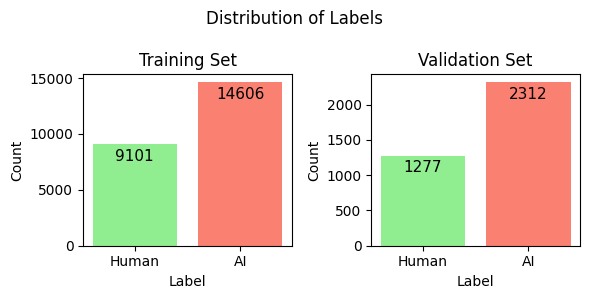

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

plot_distribution(axes[0], train_df, "Training Set")
plot_distribution(axes[1], val_df, "Validation Set")

plt.suptitle("Distribution of Labels")
plt.tight_layout()
plt.show()

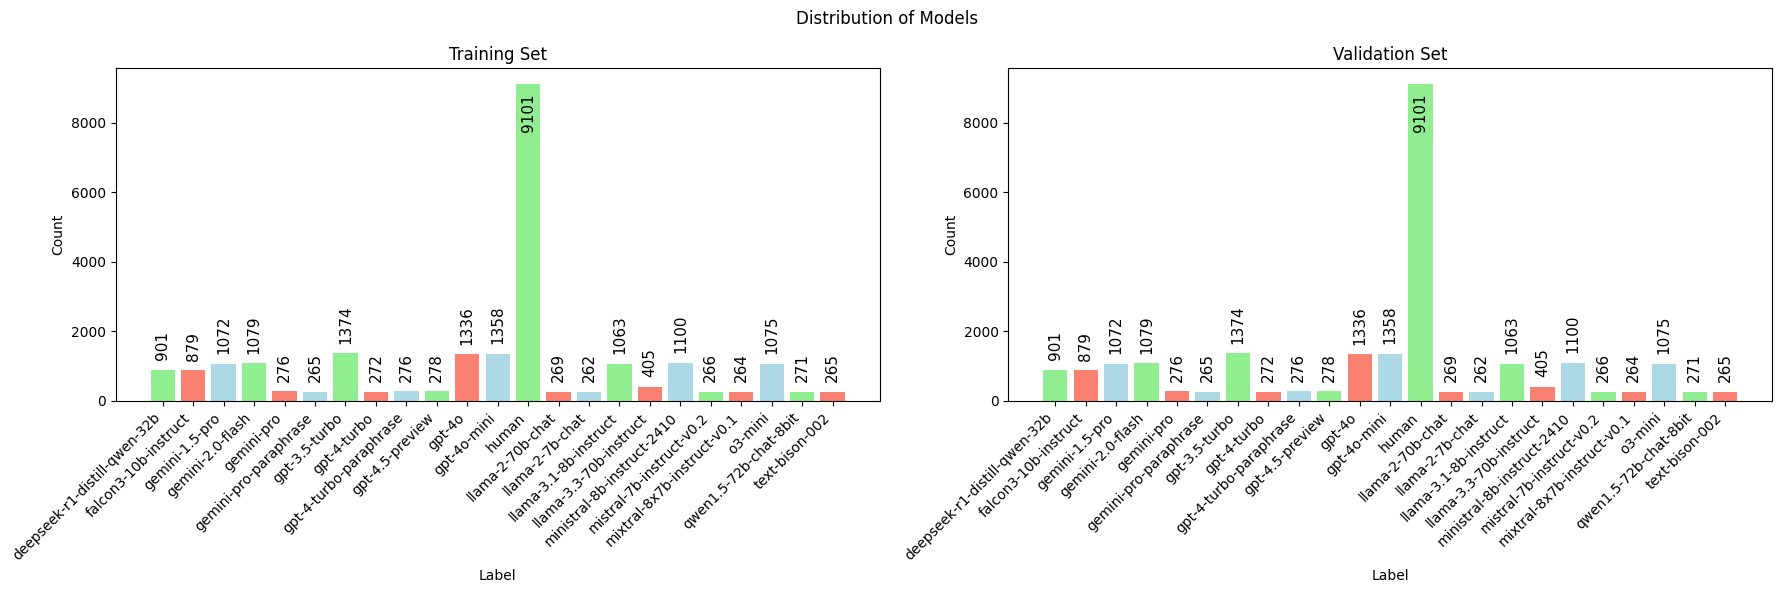

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

plot_distribution(axes[0], train_df, "Training Set", label_col="model", labels={mod: mod for mod in train_df["model"].unique()}, rotated_labels=True, rotated_values=True)
plot_distribution(axes[1], train_df, "Validation Set", label_col="model", labels={mod: mod for mod in val_df["model"].unique()}, rotated_labels=True, rotated_values=True)

plt.suptitle("Distribution of Models")
plt.tight_layout()
plt.show()

Next of, we analyze the length of texts in the dataset. We plot the distribution of the lengths of instances, focusing on the total number of words. Furthermore, we look at the relationship between the total number of words and the number of unique words in the texts.

In [9]:
word_counts = train_df["text"].str.split(" ").list
word_counts = pl.DataFrame({
    "total": word_counts.len(),
    "unique": word_counts.n_unique(),
})
label_word_counts = word_counts.with_columns(train_df["label"])

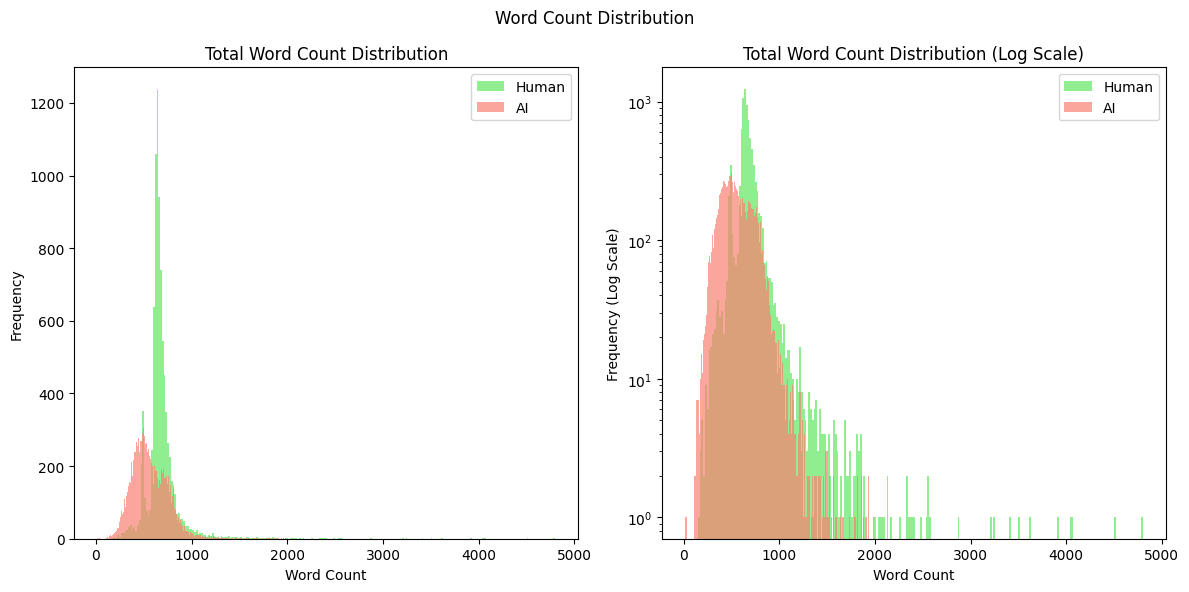

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Plot histogram of total word counts for each label
axes[0].hist(label_word_counts.filter(pl.col("label") == 0).select(pl.col("total")), bins=250, color="lightgreen", alpha=1, label="Human")
axes[0].hist(label_word_counts.filter(pl.col("label") == 1).select(pl.col("total")), bins=250, color="salmon", alpha=0.7, label="AI")
axes[0].set_title("Total Word Count Distribution")
axes[0].set_xlabel("Word Count")
axes[0].set_ylabel("Frequency")
axes[0].legend()
# Plot histogram of total word counts for each label (log scale)
axes[1].hist(label_word_counts.filter(pl.col("label") == 0).select(pl.col("total")), bins=250, color="lightgreen", alpha=1, label="Human")
axes[1].hist(label_word_counts.filter(pl.col("label") == 1).select(pl.col("total")), bins=250, color="salmon", alpha=0.7, label="AI")
axes[1].set_title("Total Word Count Distribution (Log Scale)")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("Frequency (Log Scale)")
axes[1].set_yscale("log")
axes[1].legend()

plt.suptitle("Word Count Distribution")
plt.tight_layout()
plt.show()

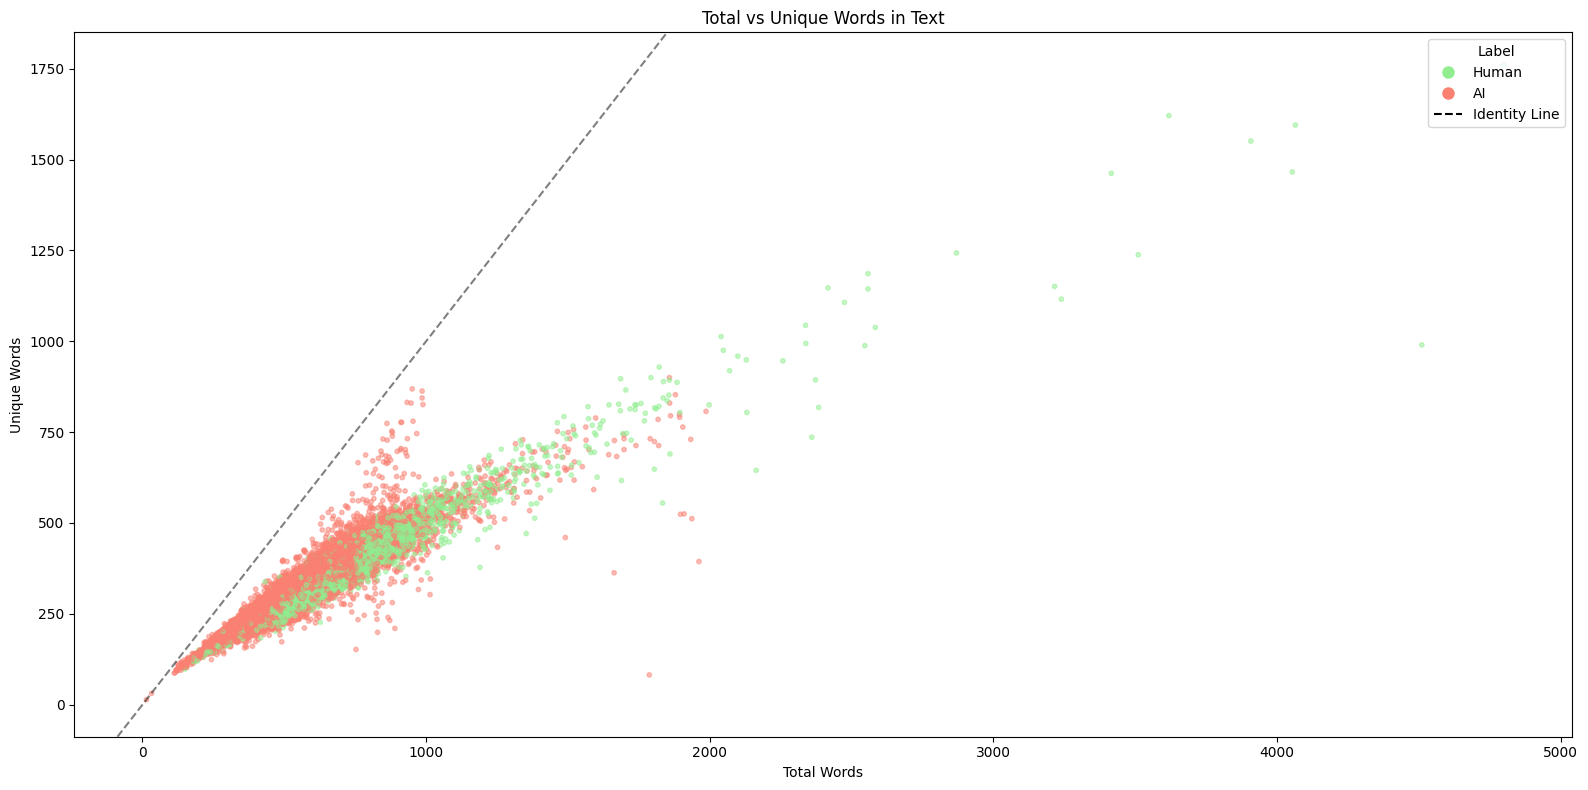

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(label_word_counts["total"], label_word_counts["unique"], alpha=0.5, s=10, c=label_word_counts["label"].map_elements(lambda x: "lightgreen" if x == 0 else "salmon", return_dtype=pl.Utf8))

# Draw first meridian line
ax.axline([0,0], slope=1, color="black", linestyle="--", label="y=x", alpha=0.5)

ax.set_xlabel("Total Words")
ax.set_ylabel("Unique Words")
ax.set_title("Total vs Unique Words in Text")

ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=labels[0], markerfacecolor='lightgreen', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label=labels[1], markerfacecolor='salmon', markersize=10),
                    plt.Line2D([0], [0], color='black', linestyle='--', label="Identity Line")],
           title="Label", loc="upper right")

plt.tight_layout()
plt.show()

We observe longer tails in the distribution of the number of words for human written texts compared to machine generated texts. Machine generated texts do not seem to exceed 2000 words. Further, the fraction of unique words in the texts is lower for human written texts compared to machine generated texts.

### Qualitative Analysis
Next, we will look at the content of the texts in the dataset and comment on specific examples and anomalies.

We observe, that Deepseek models sometimes generate texts with mandarin characters.

In [12]:
train_df.filter(train_df["id"].is_in(["bf05df4b-d259-5480-b3e5-de7f536bdbd8", "c52e2240-a244-5220-896b-80a075e43541"])).select(["text", "model", "label"]).to_dicts()


[{'text': 'In the dim glow of the smithy’s forge, where the smoky air hung heavy with the scent of burning charcoal, there lay a crevice of shadow beneath the rough-hewn beams. It was here that David Grieve had secreted his cherished pan, aWhilst the rest of the world moved on with its bustling activities, David remained oblivious, lost in the intricate details of his tiny vessels. The pan, a relic of industrial refuse, had become the cornerstone of his solitude, a portal to realms of adventure beyond the confines of his troubled life. The water within the pan, though still and reflective, shimmered like a hidden lake, its surface unruffled by the tumult around him. Here, in this secluded corner, David found his solace, his escape from the relentless clatter of reality.\n\nThe pan, a worn and battered vessel, held within it the promise of endless journeys.小船在其中轻轻摇曳，仿佛乘风破浪，驶向遥远的未知之地。David, with the meticulous care of a seafarer charting unexplored waters, had crafted each boat with prec